#  IN3050/IN4050 Mandatory Assignment 1: Traveling Salesman Problem (Solution, Petter Rødal)


## Introduction
In this exercise, you will attempt to solve an instance of the traveling salesman problem (TSP) using different
methods. The goal is to become familiar with evolutionary algorithms and to appreciate their effectiveness on a
difficult search problem. You have to use Python to solve the assignment. You must write
your program from scratch (but you may use non-EA-related libraries).


|  &nbsp;   | Barcelona | Belgrade |  Berlin | Brussels | Bucharest | Budapest |
|:---------:|:---------:|:--------:|:-------:|:--------:|:---------:|:--------:|
| Barcelona |     0     |  1528.13 | 1497.61 |  1062.89 |  1968.42  |  1498.79 |
|  Belgrade |  1528.13  |     0    |  999.25 |  1372.59 |   447.34  |  316.41  |
|   Berlin  |  1497.61  |  999.25  |    0    |  651.62  |  1293.40  |  1293.40 |
|  Brussels |  1062.89  |  1372.59 |  651.62 |     0    |  1769.69  |  1131.52 |
| Bucharest |  1968.42  |  447.34  | 1293.40 |  1769.69 |     0     |  639.77  |
|  Budapest |  1498.79  |  316.41  | 1293.40 |  1131.52 |   639.77  |     0    |


<center>Figure 1: First 6 cities from csv file.</center>


## Problem
The traveling salesman, wishing to disturb the residents of the major cities in some region of the world in
the shortest time possible, is faced with the problem of finding the shortest tour among the cities. A tour
is a path that starts in one city, visits all of the other cities, and then returns to the starting point. The
relevant pieces of information, then, are the cities and the distances between them. In this instance of the
TSP, a number of European cities are to be visited. Their relative distances are given in the data file, *european_cities.csv*, found in the zip file with the mandatory assignment.

(You will use permutations to represent tours in your programs. The **itertools** module in Python provides
a permutations function that returns successive permutations, this is useful for exhaustive search)

## Helper code for visualizing solutions

Here follows some helper code that you can use to visualize the plans you generate. These visualizations can **help you check if you are making sensible tours or not**. The optimization algoritms below should hopefully find relatively nice looking tours, but perhaps with a few visible inefficiencies.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(57)
#Map of Europe
europe_map = plt.imread('map.png')

#Lists of city coordinates
city_coords = {
    "Barcelona": [2.154007, 41.390205], "Belgrade": [20.46, 44.79], "Berlin": [13.40, 52.52], 
    "Brussels": [4.35, 50.85], "Bucharest": [26.10, 44.44], "Budapest": [19.04, 47.50],
    "Copenhagen": [12.57, 55.68], "Dublin": [-6.27, 53.35], "Hamburg": [9.99, 53.55], 
    "Istanbul": [28.98, 41.02], "Kyiv": [30.52, 50.45], "London": [-0.12, 51.51], 
    "Madrid": [-3.70, 40.42], "Milan": [9.19, 45.46], "Moscow": [37.62, 55.75],
    "Munich": [11.58, 48.14], "Paris": [2.35, 48.86], "Prague": [14.42, 50.07],
    "Rome": [12.50, 41.90], "Saint Petersburg": [30.31, 59.94], "Sofia": [23.32, 42.70],
    "Stockholm": [18.06, 60.33], "Vienna": [16.36, 48.21], "Warsaw": [21.02, 52.24]}


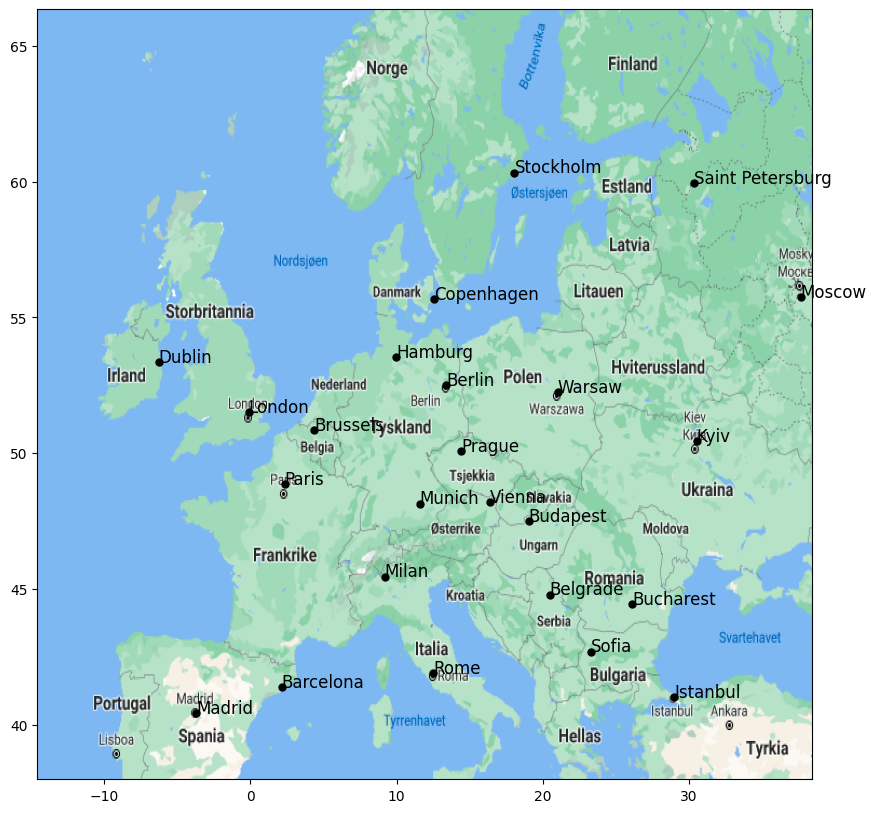

In [5]:
#Helper code for plotting plans
#First, visualizing the cities.
import csv
with open("european_cities.csv", "r") as f:
    data = list(csv.reader(f, delimiter=';'))
    cities = data[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

# Map (long, lat) to (x, y) for plotting
for city, location in city_coords.items():
    x, y = (location[0], location[1])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, city, fontsize=12)


In [6]:
#A method you can use to plot your plan on the map.
def plot_plan(city_order):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

    # Map (long, lat) to (x, y) for plotting
    for index in range(len(city_order) - 1):
        current_city_coords = city_coords[city_order[index]]
        next_city_coords = city_coords[city_order[index+1]]
        x, y = current_city_coords[0], current_city_coords[1]
        #Plotting a line to the next city
        next_x, next_y = next_city_coords[0], next_city_coords[1]
        plt.plot([x, next_x], [y, next_y])

        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, index, fontsize=12)
    #Finally, plotting from last to first city
    first_city_coords = city_coords[city_order[0]]
    first_x, first_y = first_city_coords[0], first_city_coords[1]
    plt.plot([next_x, first_x], [next_y, first_y])
    #Plotting a marker and index for the final city
    plt.plot(next_x, next_y, 'ok', markersize=5)
    plt.text(next_x, next_y, index+1, fontsize=12)
    plt.show()


['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin', 'Hamburg', 'Istanbul', 'Kyiv', 'London', 'Madrid', 'Milan', 'Moscow', 'Munich', 'Paris', 'Prague', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm', 'Vienna', 'Warsaw']


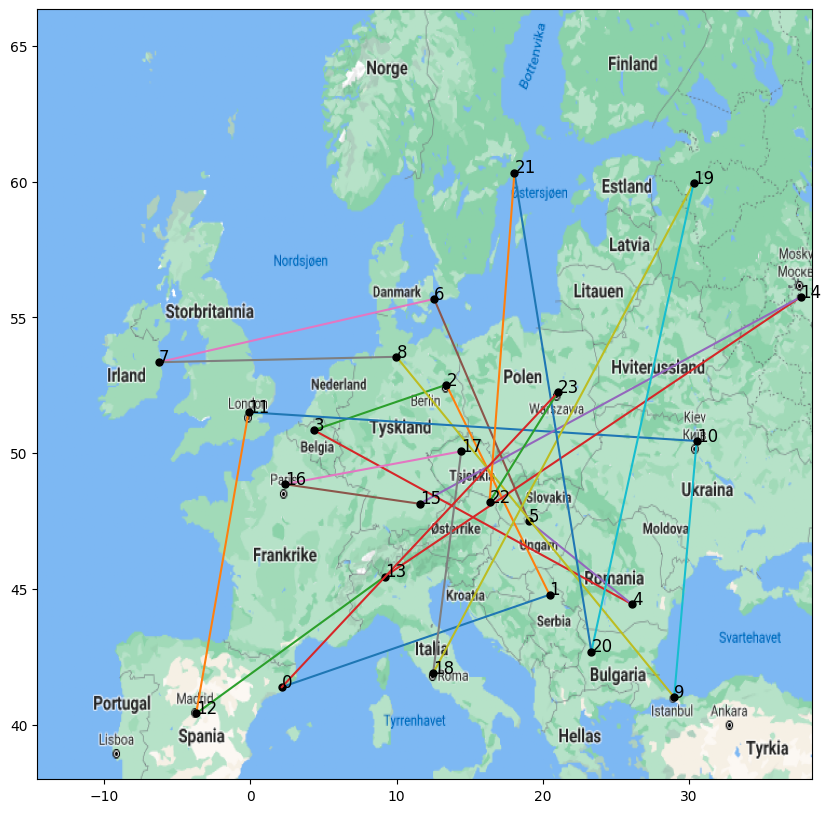

In [7]:
#Example usage of the plotting-method.
plan = list(city_coords.keys()) # Gives us the cities in alphabetic order
print(plan)
plot_plan(plan)

## Exhaustive Search
First, try to solve the problem by inspecting every possible tour. Start by writing a program to find the shortest
tour among a subset of the cities (say, **6** of them). Measure the amount of time your program takes. Incrementally
add more cities and observe how the time increases. Plot the shortest tours you found using the plot_plan method above, for 6 and 10 cities.

**Note:** To get distances between cities, use the dictionary `data` created by reading the file `european_cities.csv`. *Do not* calculate distances based on the coordinates. The actual distances do not only depend on the differences in the coordinates, but also of the curvature of the earth. The distances available in `data` are corrected for this, and contain the actual true distances.

Best order: ['Barcelona', 'Belgrade', 'Bucharest', 'Budapest', 'Berlin', 'Brussels']
Best distance: 5018.81
Total running time: 0.005 seconds


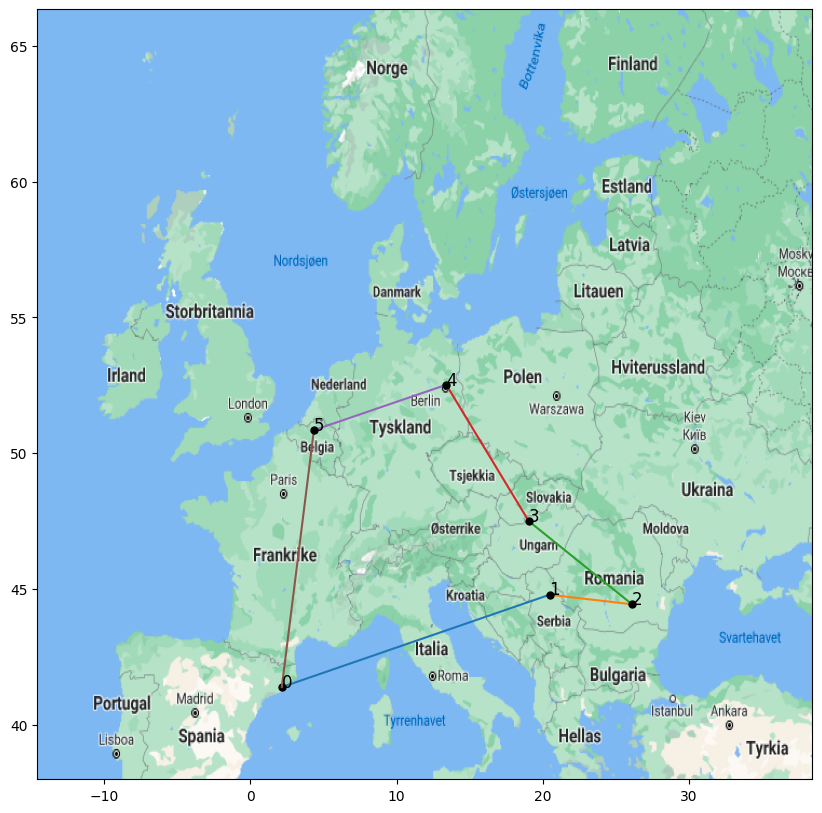

In [27]:
# Implement the algorithm here

from itertools import permutations

import time

start = time.time()

cities = plan[:6] #Numbers of cities used

def calculate_total_distance(order, distances): #Function that calculates the total distance based on city order. NB!  This function is auto generated using CHATgpt.
   
   total_distance = 0
   for i in range(len(order) - 1): 
      total_distance += distances[order[i]][order[i + 1]]
   total_distance += distances[order[-1]][order[0]]
   return total_distance


def exhaustive_search(distances, cities):

   num_cities = len(cities)
   cities = list(range(num_cities)) #Cities as different int values, instead of string

   #print(cities) #For testing

   
   all_pos_orders = permutations(cities) #Gets all the different orders possible for the cities. 

   best_tour = None

   best_distance = float("inf") #Placeholder

   for tour in all_pos_orders: #Goes through all the orders picks the best one (shortest distance).
      current_distance = calculate_total_distance(tour, distances)
      
      if current_distance < best_distance:
         best_distance = current_distance
         best_tour = tour

   return best_tour, best_distance


def data_to_float(length):  #Function that gets the data from the csv file and converts it to float

   with open('european_cities.csv', 'r') as file:
      csv_reader = csv.reader(file, delimiter = ';')

      #Skips first row since that row is only city names
      header = next(csv_reader, None)


      data = [next(csv_reader)[:len(cities)] for _ in range(len(cities))] #Gets the rows and columns from csv file needed 

   distances = np.array(data, dtype=str)
   
   #Converts the data from string to float
   distances = [
    [float(element) for element in row] 
    for row in distances
   ]

   return distances


city_distances = data_to_float(cities)


best_order, best_distance = exhaustive_search(city_distances, cities)

best_order = list(best_order)

best_city_order = [cities[i] for i in best_order] #Gets the cities from the best order 

end_time = time.time()
total_time = end_time - start #Calculate total running time


print("Best order:", best_city_order)
print("Best distance:", round(best_distance, 2))
print(f"Total running time: {round(total_time, 3)} seconds")

plot_plan(best_city_order)


     

What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is,
the cities starting with B,C,D,H and I)? How long did your program take to find it? Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

In [7]:
# Answer

#Aswered in the report

## Hill Climbing
Then, write a simple hill climber to solve the TSP. How well does the hill climber perform, compared to the result from the exhaustive search for the first **10 cities**? Since you are dealing with a stochastic algorithm, you
should run the algorithm several times to measure its performance. Report the length of the tour of the best,
worst and mean of 20 runs (with random starting tours), as well as the standard deviation of the runs, both with the **10 first cities**, and with all **24 cities**. Plot one of the the plans from the 20 runs for both 10 cities and 24 cities (you can use plot_plan). 

Best Distance: 12870.74
Worst Distance: 16144.37
Mean distance: 14980.24
Standard Deviation: 880.96
Best tour: ['Istanbul', 'Kyiv', 'Moscow', 'Saint Petersburg', 'Stockholm', 'Copenhagen', 'Brussels', 'Paris', 'London', 'Dublin', 'Madrid', 'Barcelona', 'Rome', 'Milan', 'Munich', 'Hamburg', 'Berlin', 'Warsaw', 'Prague', 'Vienna', 'Budapest', 'Belgrade', 'Sofia', 'Bucharest']


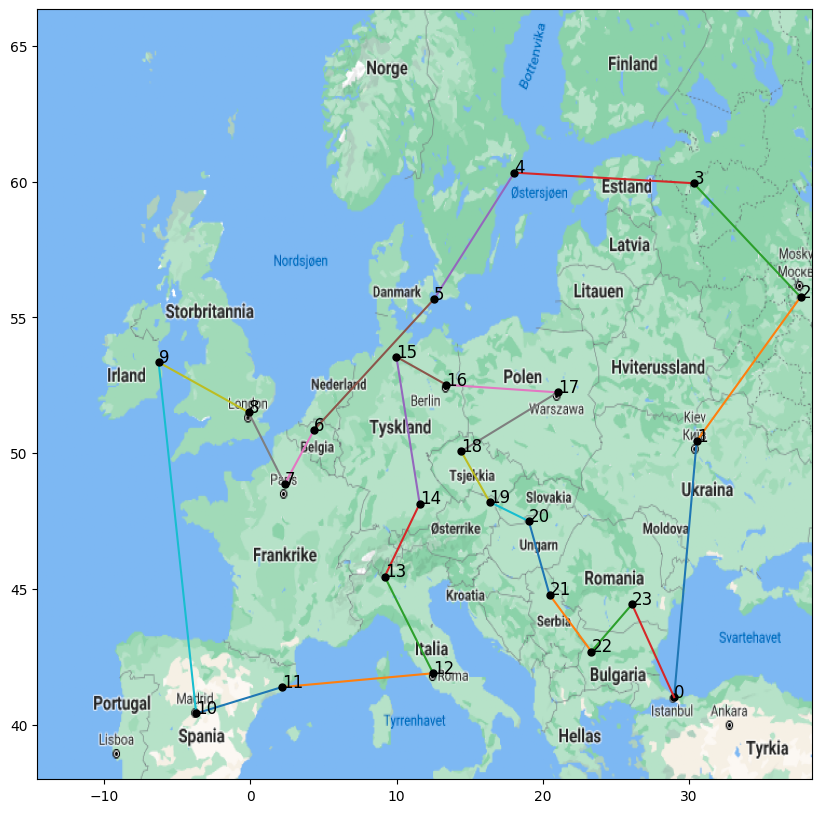

In [9]:
# Implement the algorithm here

#Choosing an inital solution randomly

#Then swapping pairs of cities in the tour, and chech if total lenght of the tour decreases

#The algrothm can stop after som pre-defined number of swaps had occured


import random

def inital_tour(cities): #Starting tour is random for each run
    return random.sample(range(cities), cities)


def calculate_total_distance(tour, distances):
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += distances[tour[i]][tour[i + 1]]
    total_distance += distances[tour[-1]][tour[0]]
    return total_distance

def hill_climbing(distances, max_swaps = 1000):
     
    num_cities = len(distances)
    current_tour = inital_tour(num_cities)
    current_distance = calculate_total_distance(current_tour, distances)

    for swaps in range(max_swaps): #1000 iterations

        new_tour = current_tour.copy() 

        city1, city2 = random.sample(range(num_cities), 2) #Pick two random cities
        new_tour[city1], new_tour[city2] = new_tour[city2], new_tour[city1] #Swaps those cities

        new_distance = calculate_total_distance(new_tour, distances) 

        if new_distance < current_distance: #If the distance is better we keep it, else we discard it.
            current_tour = new_tour
            current_distance = new_distance

    return current_tour, current_distance


def multiple_runs(distances, num_runs = 20, max_swaps = 1000): #Function that runs the algorithm several times
    best_tours = []
    worst_tours = []
    distances_list = []

    for _ in range(num_runs):
        tour, distance = hill_climbing(distances, max_swaps)
        best_tours.append(tour)
        worst_tours.append(tour[::-1]) #Reverse of the best tours list
        distances_list.append(distance)

    best_ind = np.argmin(distances_list)
    worst_ind = np.argmax(distances_list)
    best_tour = best_tours[best_ind]
    worst_tour = worst_tours[worst_ind]
    std_dev = np.std(distances_list)
    mean = np.mean(distances_list)

    return best_tour, distances_list[best_ind], worst_tour, distances_list[worst_ind], std_dev, mean





cities = plan[:24]

city_distances = data_to_float(cities)


# Run the hill climbing algorithm multiple times
best_tour, best_distance, worst_tour, worst_distance, std_deviation, mean = multiple_runs(city_distances)


print("Best Distance:", round(best_distance, 2))
print("Worst Distance:", round(worst_distance,2))
print("Mean distance:", round((mean), 2))
print("Standard Deviation:", round(std_deviation, 2))

best_tour = list(best_tour)

best_city_tour = [cities[i] for i in best_tour]




print("Best tour:", best_city_tour)


plot_plan(best_city_tour)


## Genetic Algorithm
Next, write a genetic algorithm (GA) to solve the problem. Choose mutation and crossover operators that are appropriate for the problem (see chapter 4.5 of the Eiben and Smith textbook). Choose three different values for the population size. Define and tune other parameters yourself and make assumptions as necessary (and report them, of course).

For all three variants: As with the hill climber, report best, worst, mean and standard deviation of tour length out of 20 runs of the algorithm (of the best individual of last generation). Also, find and plot the average fitness of the best fit individual in each generation (average across runs), and include a figure with all three curves in the same plot in the report. This means that the x-axis should be the generations over time and the y-axis should be the average (over the 20-runs) fitness of the best gene in that generation. Conclude which is best in terms of tour length and number of generations of evolution time.

Finally, plot an example optimized tour (the best of the final generation) for the three different population sizes, using the plot_plan method.

For population size of 3, the best fit individuals in last generation: 
Best Distance: 21031.92
Worst Distance: 21031.92
Mean distance: 21031.92
Standard Deviation: 0.0



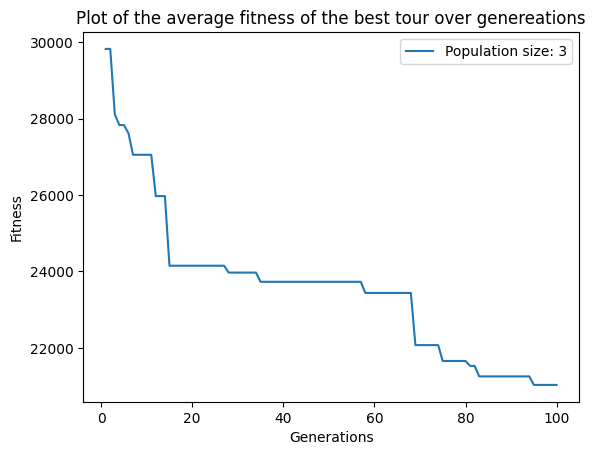

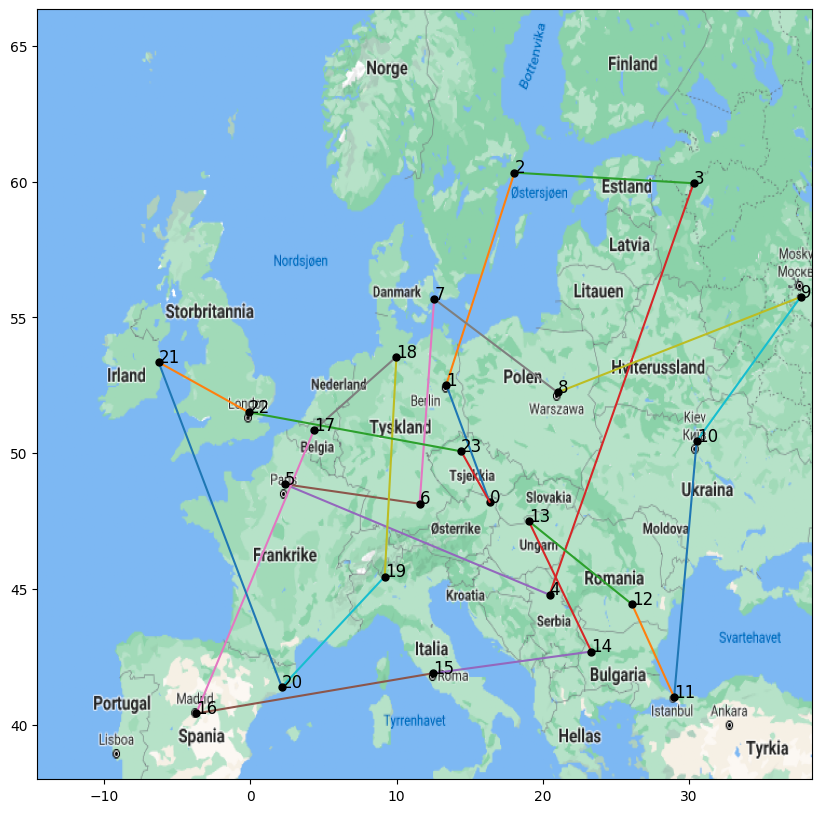

Total running time: 4.84 seconds


In [13]:
# Implement the algorithm here

#Reprsentation: Candidate solutions is representated as a permutation of the cities. Each gene in the chromosome represent a city, and the order of the genes corresponds to the order in whcich the cities are visited. 

import random

start2 = time.time()

cities = plan[:24]

#Will be using swap mutation

def swap_mutation(offspring):
    index1, index2 = random.sample(range(len(offspring)), 2) #Pick to random indices (genes) in the offspring and swaps them

    offspring[index1], offspring[index2] = offspring[index2], offspring[index1]

    return offspring


def order_crossover(parent1, parent2):
    offspring1 = [None] * len(parent1) 
    offspring2 = [None] * len(parent2)

    start, end = sorted(random.sample(range(len(parent1)),2)) #Pick to random indicies (genes)

    segment1 = parent1[start:end] #Gets the genes between the indices

    offspring1[start:end] = segment1 #Adds those to the offspring
 
    P_missing = []
    P_missing.extend(value for value in parent1 if value not in segment1) #Find the remaining genes that needs to be transferred in order in which thay appear in parent2
    P_missing.sort(key=lambda x: parent2.index(x))

    testing = []

    offspring1[0:start] = P_missing[0:start] #Adds the reamining genes to the offspring
    testing.extend(value for value in P_missing if value not in offspring1) 
    offspring1[end:len(parent1)] = testing

    #Creating the second offspring with parents role reversed 

    segment2 = parent2[start:end]

    offspring2[start:end] = segment2

    P_missing2 = []
    P_missing2.extend(value for value in parent2 if value not in segment2)
    P_missing2.sort(key=lambda x: parent1.index(x))

    testing2 = []

    offspring2[0:start] = P_missing2[0:start]
    testing2.extend(value for value in P_missing2 if value not in offspring2)
    offspring2[end:len(parent2)] = testing2


    return offspring1, offspring2


#Ranking selection
def parent_selection(population, selection_pressure = 1.5):
    population_size = len(population)

    
    fitness_scores = []
    for pop in population:
        
        dic = data_to_float(pop)
        
        fitness = calculate_total_distance(pop, dic)
        fitness_scores.append(fitness)



    ranked_population = sorted(population, key=lambda x: calculate_total_distance(x, data_to_float(x))) #Sortes the population based on fitness
    


    prob_list = [] #List of the probabilties of being selected as a parent, which is propotional to the rankings
    i = 0
    for i in range(len(ranked_population)):
        probality = ((2 - selection_pressure) / population_size) + (2 * i * (selection_pressure - 1)) / (population_size * (population_size - 1))
        prob_list.append(probality)
        i += 1
    
    selected_parents = []
    
    #Using roulettte wheel to select the parent

    #NB this implmentation is auto generated using CHATgpt

    while True:
        rand_num1 = random.random()
        try:
            selected_parent_index1 = next(i for i, prob in enumerate(prob_list) if prob >= rand_num1)
            break
        except StopIteration:
            pass

    parent1 = ranked_population[selected_parent_index1]

    selected_parents.append(parent1)

    # Select the second parent and ensuring it's different from the first parent
    while True:
        rand_num2 = random.random()
        selected_parent_index2 = next((i for i, prob in enumerate(prob_list) if prob >= rand_num2), None)
        if selected_parent_index2 is not None and selected_parent_index2 != selected_parent_index1:
            parent2 = ranked_population[selected_parent_index2]
            break
    
    selected_parents.append(parent2)

    return parent1, parent2

    
def inital_tour(cities):
    return random.sample(range(cities), cities)



def survivor_selection(population ,offspring1 ,offspring2):
    survivors = []

    for ele in population:
        survivors.append(ele)
    
    survivors.append(offspring1)
    survivors.append(offspring2)
    
    survivors_test = sorted(survivors, key=lambda x: calculate_total_distance(x, data_to_float(x))) #Picking the fitess in the new population
    

    survivor_selected = []
    survivor_selected.extend(survivors_test[:len(survivors) - 2]) #Ensuring the population dosen't increase or decrease

    #print(survivor_selected)

    survivors.clear()

    return survivor_selected

        


def tsp_genetic_algorithm(cities, population_size, generations):
    num_cities = len(cities)
    population = []

    for _ in range(population_size):
        population.append(inital_tour(num_cities))

    
    y_axis = []

    for _ in range(generations):
        #population = sorted(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
        parent1, parent2 = parent_selection(population)
        offspring1, offspring2 = order_crossover(parent1, parent2)
       
        offspring1 = swap_mutation(offspring1)
        offspring2 = swap_mutation(offspring2)
    
        population = survivor_selection(population, offspring1, offspring2)
        best_tours = min(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
        y_axis.append(calculate_total_distance(best_tours, data_to_float(best_tours)))




    best_tour = min(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
   
    return best_tour, calculate_total_distance(best_tour, data_to_float(best_tour)), y_axis



# Generating x-axis values from 1 to 100 for plotting
x_values = list(range(1, 101))



def tsp_multiple_runs(diff_populations, iterations):

    best_tours = []
    
    avarage_best_tour = np.empty((0, iterations), dtype=float) 
    for _ in range(20):
        besttour, disctance, potter = tsp_genetic_algorithm(cities, diff_populations, iterations)
        avarage_best_tour = np.vstack([avarage_best_tour, potter]) #Stacks all the best tours in a array, so its easier to find the avarage best tour for each generation
        best_tours.append(besttour)
        
    average_over_gen = np.mean(avarage_best_tour, axis=0) #Gets the avarage for each column (=Generation) in array.
    average_list = average_over_gen.tolist()

    abs_best_tour = min(best_tours, key=lambda x: calculate_total_distance(x, data_to_float(x))) 

    best_fit_ind = avarage_best_tour[:, iterations - 1] #Adds the last individuals in the last generation to a list

    best_distances_tsp = np.min(best_fit_ind)
    worst_distances_tsp = np.max(best_fit_ind)
    mean_dis = np.mean(best_fit_ind)
    std_dev = np.std(best_fit_ind)

    return average_list, best_distances_tsp, worst_distances_tsp, mean_dis, std_dev, abs_best_tour


population_sizes = [3, 5, 10]

plotting_cities = []

for pop in population_sizes:
    test1, be, wo, mean, std, best = tsp_multiple_runs(pop, 100)
    print(f"For population size of {pop}, the best fit individuals in last generation: ")
    print("Best Distance:", round(be, 2))
    print("Worst Distance:", round(wo,2))
    print("Mean distance:", round((mean), 2))
    print("Standard Deviation:", round(std, 2))
    print("")
    plt.plot(x_values, test1, label=f'Population size: {pop}', marker='')
    best_cities =  [cities[i] for i in best]
    plotting_cities.append(best_cities)

    



# Creating the plot

plt.title('Plot of the average fitness of the best tour over genereations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend()

plt.show()


for tours in plotting_cities:
    plot_plan(tours)

end_time2 = time.time()
total_time2 = end_time2 - start2
print(f"Total running time: {round(total_time2, 3)} seconds")


Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close? 

For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search? 

How many tours were inspected by your GA as compared to by the exhaustive search?

In [10]:
# Answer

#Answered in the report. 

## Hybrid Algorithm (IN4050 only)
### Lamarckian
Lamarck, 1809: Traits acquired in parents’ lifetimes can be inherited by offspring. In general the algorithms are referred to as Lamarckian if the result of the local search stage replaces the individual in the population.
### Baldwinian
Baldwin effect suggests a mechanism whereby evolutionary progress can be guided towards favourable adaptation without the changes in individual's fitness arising from learning or development being reflected in changed genetic characteristics. In general the algorithms are referred to as Baldwinian if the original member is kept, but has as its fitness the value belonging to the outcome of the local search process.


(See chapter 10 and 10.2.1 from Eiben and Smith textbook for more details. It will also be lectured in Lecure 4)

### Task
Implement a hybrid algorithm to solve the TSP: Couple your GA and hill climber by running the hill climber a number of iterations on each individual in the population as part of the evaluation. Test both Lamarckian and Baldwinian learning models and report the results of both variants in the same way as with the pure GA (min,
max, mean and standard deviation of the end result and an averaged generational plot). How do the results compare to that of the pure GA, considering the number of evaluations done?

For population size of 3, the best fit individuals in last generation: 
Best Distance: 16168.88
Worst Distance: 20904.97
Mean distance: 18896.29
Standard Deviation: 1226.59

For population size of 5, the best fit individuals in last generation: 
Best Distance: 16640.07
Worst Distance: 21585.01
Mean distance: 19447.31
Standard Deviation: 1099.32

For population size of 10, the best fit individuals in last generation: 
Best Distance: 17491.92
Worst Distance: 22454.69
Mean distance: 19833.99
Standard Deviation: 1253.84



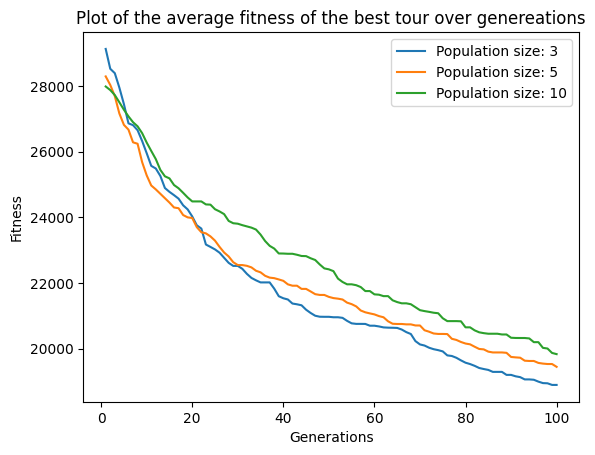

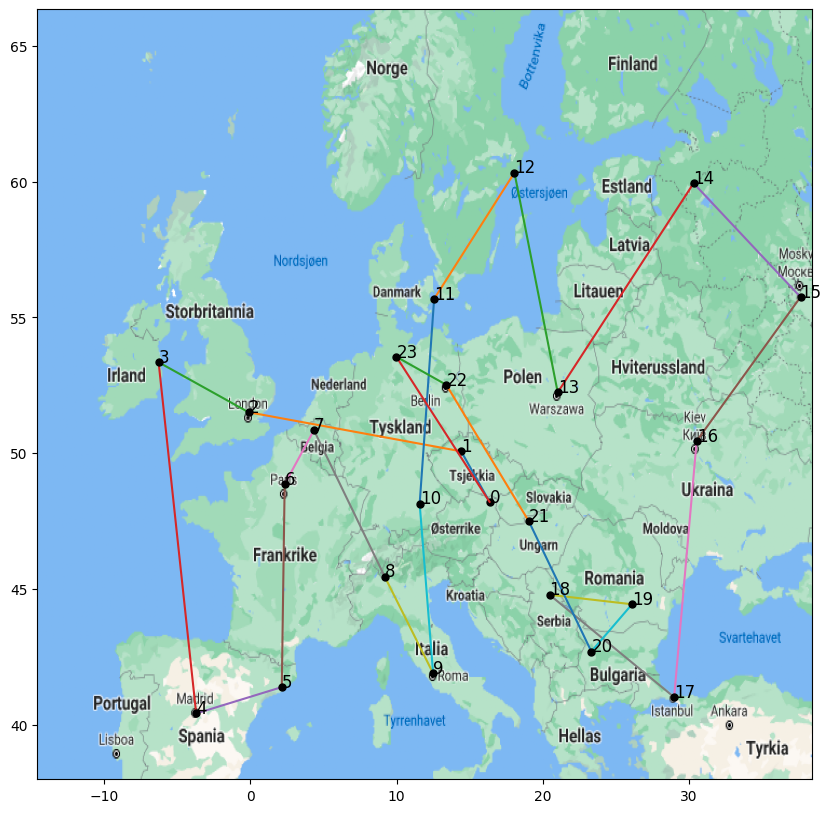

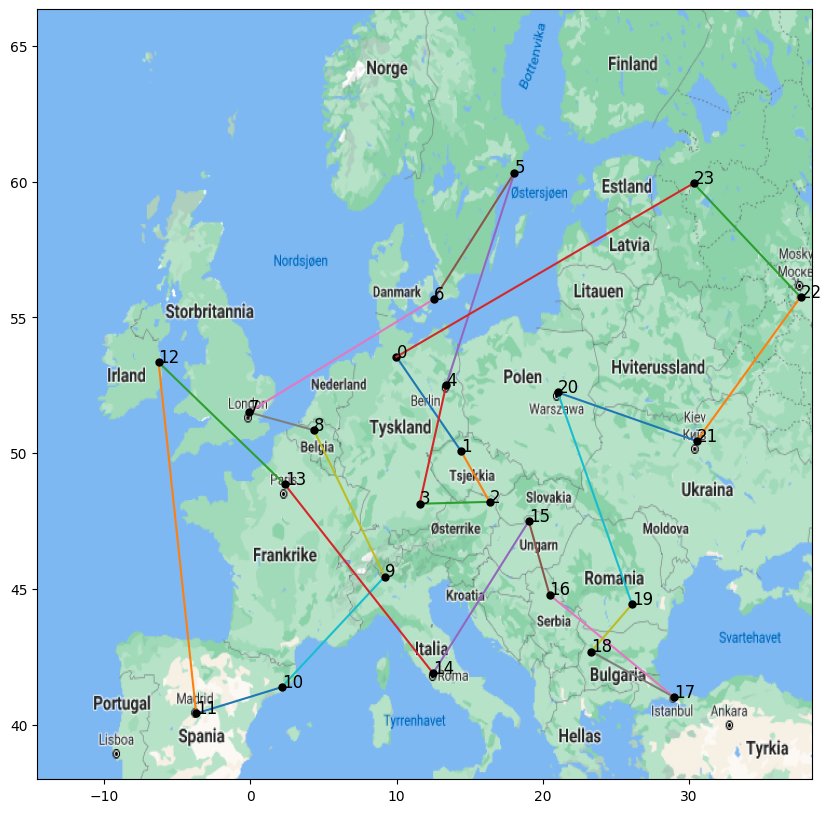

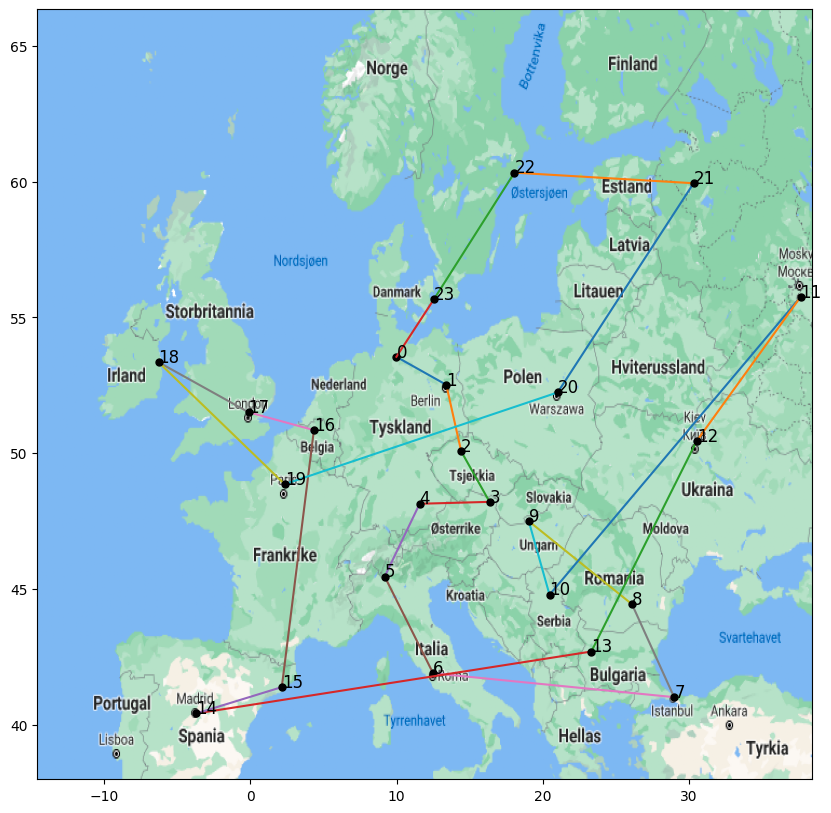

In [16]:
# Implement algorithm here

def lamarckian(offspring1, offspring2, iterasjons = 20):
  
    num_cities = len(offspring1)

    offsprings = []
    offsprings.append(offspring1)
    offsprings.append(offspring2)
    
    for ele in offsprings: #Make the offspring go through the Hill Climbing 20 times

       current_tour = ele
       current_distance = calculate_total_distance(current_tour, data_to_float(ele))

       for swaps in range(iterasjons):

           new_tour = current_tour.copy()
           city1, city2 = random.sample(range(num_cities), 2)
           new_tour[city1], new_tour[city2] = new_tour[city2], new_tour[city1] 

           new_distance = calculate_total_distance(new_tour, data_to_float(ele))

           if new_distance < current_distance:
               current_tour = new_tour
               current_distance = new_distance

    offspring1 = offsprings[0]
    offspring2 = offsprings[1]

    return offspring1, offspring2

    



def tsp_lamarckian(cities, population_size, generations):
    num_cities = len(cities)
    population = []

    for _ in range(population_size):
        population.append(inital_tour(num_cities))

    
    y_axis = []

    for _ in range(generations):
        #population = sorted(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
        parent1, parent2 = parent_selection(population)
        
        offspring1, offspring2 = order_crossover(parent1, parent2)

        offspring1, offspring2 = lamarckian(offspring1, offspring2)
        
        offspring1 = swap_mutation(offspring1)
        offspring2 = swap_mutation(offspring2)
    
        population = survivor_selection(population, offspring1, offspring2)
        best_tours = min(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
        y_axis.append(calculate_total_distance(best_tours, data_to_float(best_tours)))




    best_tour = min(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
   
    return best_tour, calculate_total_distance(best_tour, data_to_float(best_tour)), y_axis

def tsp_multiple_runs_lamarckian(diff_populations, iterations):

    best_tours = []
    
    avarage_best_tour = np.empty((0, iterations), dtype=float) 
    for _ in range(20):
        besttour, disctance, potter = tsp_lamarckian(cities, diff_populations, iterations)
        avarage_best_tour = np.vstack([avarage_best_tour, potter])
        best_tours.append(besttour)
        
    average_over_gen = np.mean(avarage_best_tour, axis=0)
    average_list = average_over_gen.tolist()

    abs_best_tour = min(best_tours, key=lambda x: calculate_total_distance(x, data_to_float(x)))

    best_fit_ind = avarage_best_tour[:, iterations - 1]

    best_distances_tsp = np.min(best_fit_ind)
    worst_distances_tsp = np.max(best_fit_ind)
    mean_dis = np.mean(best_fit_ind)
    std_dev = np.std(best_fit_ind)

    return average_list, best_distances_tsp, worst_distances_tsp, mean_dis, std_dev, abs_best_tour

cities = plan[:24]

population_sizes = [3, 5, 10]

plotting_cities = []

for pop in population_sizes:
    test1, be, wo, mean, std, best = tsp_multiple_runs_lamarckian(pop, 100)
    print(f"For population size of {pop}, the best fit individuals in last generation: ")
    print("Best Distance:", round(be, 2))
    print("Worst Distance:", round(wo,2))
    print("Mean distance:", round((mean), 2))
    print("Standard Deviation:", round(std, 2))
    print("")
    plt.plot(x_values, test1, label=f'Population size: {pop}', marker='')
    best_cities =  [cities[i] for i in best]
    plotting_cities.append(best_cities)

    



# Creating the plot

plt.title('Plot of the average fitness of the best tour over genereations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend()

plt.show()


for tours in plotting_cities:
    plot_plan(tours)

For population size of 3, the best fit individuals in last generation: 
Best Distance: 16684.19
Worst Distance: 21288.63
Mean distance: 18723.59
Standard Deviation: 1300.61

For population size of 5, the best fit individuals in last generation: 
Best Distance: 17782.24
Worst Distance: 21927.84
Mean distance: 19463.08
Standard Deviation: 969.25

For population size of 10, the best fit individuals in last generation: 
Best Distance: 18856.69
Worst Distance: 22060.43
Mean distance: 20382.15
Standard Deviation: 910.66



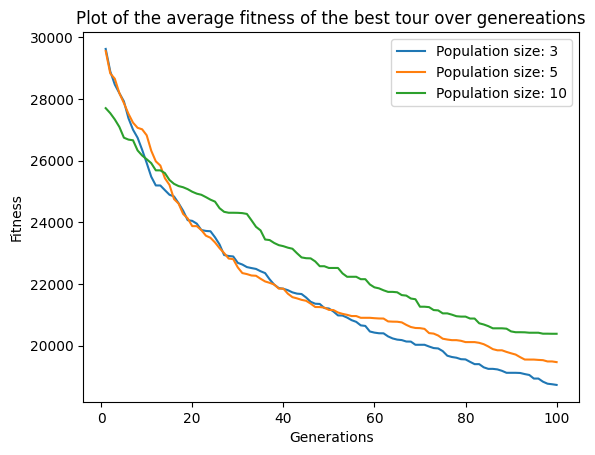

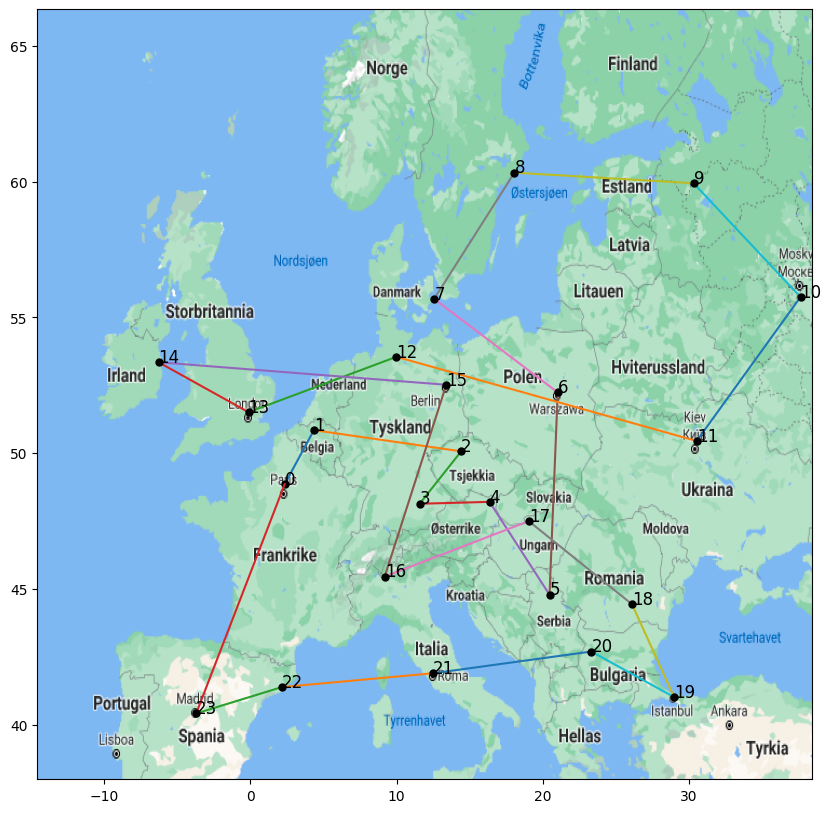

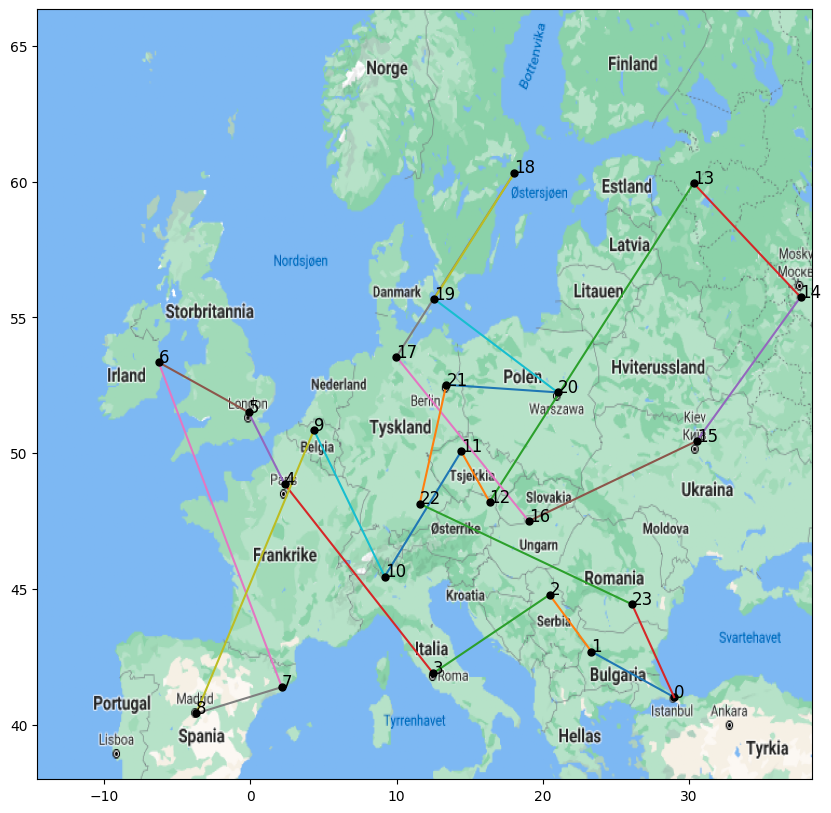

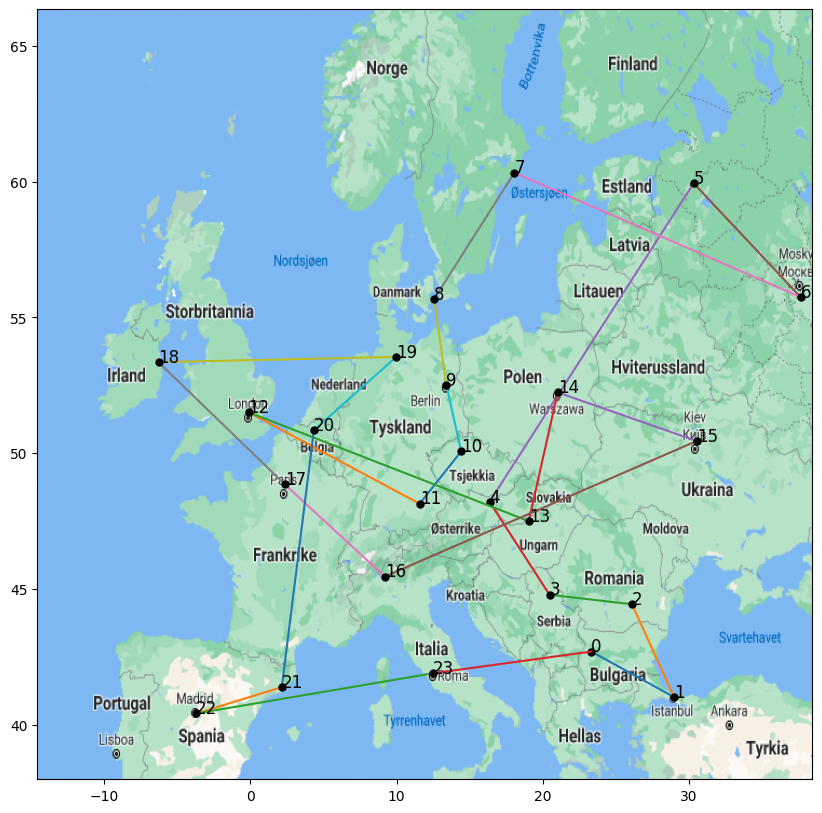

In [17]:
#Baldwin

def baldwin(population, iterations = 20):
    
    pop_list = []

    for pop in population:
        pop_list.append(pop)

    probabilities = []
    rankings = []    

    #Each individual runs through the Hill Climbing 20 times
    
    for ele in pop_list:

       current_tour = ele
       current_distance = calculate_total_distance(current_tour, data_to_float(ele))
       num_cities = len(ele)

       for swaps in range(iterations):

           new_tour = current_tour.copy()
           city1, city2 = random.sample(range(num_cities), 2)
           new_tour[city1], new_tour[city2] = new_tour[city2], new_tour[city1] 

           new_distance = calculate_total_distance(new_tour, data_to_float(ele))

           if new_distance < current_distance:
               current_tour = new_tour
               current_distance = new_distance
            
       rankings.append(current_tour) #Add the individual (tours) to a new list after Hill Climbing
     
    
    ranked_population = sorted(rankings, key=lambda x: calculate_total_distance(x, data_to_float(x))) 

    sorted_indices = sorted(range(len(rankings)), key=lambda k: calculate_total_distance(rankings[k], data_to_float(rankings[k]))) #Then sorts the individuals based on their fitness/distance

    r_list = [pop_list[i] for i in sorted_indices] #Sort the original population based on their values after the hill climbing, but they don't get replaced by the result from Hill Climbing
 
    selection_pressure = 1.5

    population_size = len(pop_list)
    
    #Using roulettte wheel to select the parent
    
    
    i = 0
    for i in range(len(ranked_population)):
        probality = ((2 - selection_pressure) / population_size) + (2 * i * (selection_pressure - 1)) / (population_size * (population_size - 1))
        probabilities.append(probality)
        i += 1       

    selected_parents = []
    
    #Using roulettte wheel to select the parent

    while True:
        rand_num1 = random.random()
        try:
            selected_parent_index1 = next(i for i, prob in enumerate(probabilities) if prob >= rand_num1)
            break
        except StopIteration:
            pass

    parent1 = r_list[selected_parent_index1]

    selected_parents.append(parent1)

    # Select the second parent and ensuring it's different from the first parent
    while True:
        rand_num2 = random.random()
        selected_parent_index2 = next((i for i, prob in enumerate(probabilities) if prob >= rand_num2), None)
        if selected_parent_index2 is not None and selected_parent_index2 != selected_parent_index1:
            parent2 = r_list[selected_parent_index2]
            break
    
    selected_parents.append(parent2)

    return parent1, parent2


def tsp_baldwin(cities, population_size, generations):
    num_cities = len(cities)
    population = []

    for _ in range(population_size):
        population.append(inital_tour(num_cities))

    
    y_axis = []

    for _ in range(generations):
        #population = sorted(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
        parent1, parent2 = baldwin(population)
        
        offspring1, offspring2 = order_crossover(parent1, parent2)
        
        offspring1 = swap_mutation(offspring1)
        offspring2 = swap_mutation(offspring2)
    
        population = survivor_selection(population, offspring1, offspring2)
        best_tours = min(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
        y_axis.append(calculate_total_distance(best_tours, data_to_float(best_tours)))




    best_tour = min(population, key=lambda x: calculate_total_distance(x, data_to_float(x)))
   
    return best_tour, calculate_total_distance(best_tour, data_to_float(best_tour)), y_axis

def tsp_multiple_runs_baldwin(diff_populations, iterations):

    best_tours = []
    
    avarage_best_tour = np.empty((0, iterations), dtype=float) 
    for _ in range(20):
        besttour, disctance, potter = tsp_baldwin(cities, diff_populations, iterations)
        avarage_best_tour = np.vstack([avarage_best_tour, potter])
        best_tours.append(besttour)
        
    average_over_gen = np.mean(avarage_best_tour, axis=0)
    average_list = average_over_gen.tolist()

    abs_best_tour = min(best_tours, key=lambda x: calculate_total_distance(x, data_to_float(x)))

    best_fit_ind = avarage_best_tour[:, iterations - 1]

    best_distances_tsp = np.min(best_fit_ind)
    worst_distances_tsp = np.max(best_fit_ind)
    mean_dis = np.mean(best_fit_ind)
    std_dev = np.std(best_fit_ind)

    return average_list, best_distances_tsp, worst_distances_tsp, mean_dis, std_dev, abs_best_tour

cities = plan[:24]

population_sizes = [3, 5, 10]

plotting_cities = []

for pop in population_sizes:
    test1, be, wo, mean, std, best = tsp_multiple_runs_baldwin(pop, 100)
    print(f"For population size of {pop}, the best fit individuals in last generation: ")
    print("Best Distance:", round(be, 2))
    print("Worst Distance:", round(wo,2))
    print("Mean distance:", round((mean), 2))
    print("Standard Deviation:", round(std, 2))
    print("")
    plt.plot(x_values, test1, label=f'Population size: {pop}', marker='')
    best_cities =  [cities[i] for i in best]
    plotting_cities.append(best_cities)

    



# Creating the plot

plt.title('Plot of the average fitness of the best tour over genereations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend()

plt.show()


for tours in plotting_cities:
    plot_plan(tours)


